In [1]:
import os
import sys
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import urllib

In [2]:
batch_size = 128
data_dir = '../data'
output_every = 50
generations = 20000
eval_every = 500
image_height = 32
image_width = 32
crop_height = 24
crop_width = 24
num_channels = 3
num_targets = 10
extract_folder = 'cifar-10-batches-bin'
learning_rate = 0.1
lr_decay = 0.1
num_gens_to_wait = 250.
image_vec_length = image_height * image_width * num_channels
record_length = 1 + image_vec_length

In [3]:
if not os.path.exists(data_dir):
    os_makedirs(data_dir)
cifar10_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
data_file = os.path.join(data_dir, 'cifar-10-binary.tar.gz')
if os.path.isfile(data_file):
    pass
else:
    def progress(block_num, block_size, total_size):
        progress_info = [cifar10_url, float(block_num * block_size) / float(total_size) * 100.0]
        print('\r Downloading {} - {:.2f}%'.format(*progress_info), end="")
    filepath, _ = urllib.request.urlretrieve(cifar10_url, data_file, progress)
    tarfile.open(filepath, 'r:gz').extractall(data_dir)

In [4]:
def read_cifar_files(filename_queue, distort_images = True):
    reader = tf.FixedLengthRecordReader(record_bytes=record_length)
    key, record_string = reader.read(filename_queue)
    record_bytes = tf.decode_raw(record_string, tf.uint8)
    
    image_label = tf.cast(tf.slice(record_bytes, [0], [1]), tf.int32)
    
    image_extracted = tf.reshape(tf.slice(record_bytes, [1], [image_vec_length]),
                                 [num_channels, image_height, image_width])
    image_uint8image = tf.transpose(image_extracted, [1, 2, 0])
    reshaped_image = tf.cast(image_uint8image, tf.float32)
    final_image = tf.image.resize_image_with_crop_or_pad(reshaped_image,
                                                         crop_width,
                                                         crop_height)
    if distort_images:
        final_image = tf.image.random_flip_left_right(final_image)
        final_image = tf.image.random_brightness(final_image, max_delta=63)
        final_image = tf.image.random_contrast(final_image, lower=0.2, upper=1.8)
    
    final_image - tf.image.per_image_standardization(final_image)
    return (final_image, image_label)

In [5]:
def input_pipeline(batch_size, train_logical=True):
    if train_logical:
        files = [os.path.join(data_dir, extract_folder, 'data_batch_{}.bin'.format(i)) for i in range(1, 6)]
    else:
        files = [os.path.join(data_dir, extract_folder, 'test_batch.bin')]
    filename_queue = tf.train.string_input_producer(files)
    image, label = read_cifar_files(filename_queue)
    
    min_after_dequeue = 5000
    capacity = min_after_dequeue + 3 * batch_size
    example_batch, label_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        capacity=capacity,
        min_after_dequeue=min_after_dequeue)
    
    return (example_batch, label_batch)

In [6]:
with tf.Session() as sess:
    def cifar_cnn_model(input_images, batch_size, train_logical=True):
        def truncated_normal_var(name, shape, dtype):
            return tf.get_variable(name=name, shape=shape, dtype=dtype,
                                   initializer=tf.truncated_normal_initializer(stddev=0.05))
        def zero_var(name, shape, dtype):
            return tf.get_variable(name=name, shape=shape, dtype=dtype,
                                   initializer=tf.constant_initializer(0.0))
        
        with tf.variable_scope('conv1') as scope:
            conv1_kernel = truncated_normal_var(name='conv_kernel1',
                                                shape=[5, 5, 3, 64],
                                                dtype=tf.float32)
            conv1 = tf.nn.conv2d(input_images, conv1_kernel, [1, 1, 1, 1], padding='SAME')
            conv1_bias = zero_var(name='conv_bias1', shape=[64], dtype=tf.float32)
            conv1_add_bias = tf.nn.bias_add(conv1, conv1_bias)
            relu_conv1 = tf.nn.relu(conv1_add_bias)
            
        pool1 = tf.nn.max_pool(relu_conv1,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool_layer1')
        norm1 = tf.nn.lrn(pool1, depth_radius=5, bias=2.0,
                          alpha=1e-3, beta=0.75, name='norm1')
        
        with tf.variable_scope('conv2') as scope:
            conv2_kernel = truncated_normal_var(name='conv_kernel2',
                                                shape=[5, 5, 64, 64],
                                                dtype=tf.float32)
            conv2 = tf.nn.conv2d(norm1, conv2_kernel, [1, 1, 1, 1], padding='SAME')
            conv2_bias = zero_var(name='conv_bias2', shape=[64], dtype=tf.float32)
            conv2_add_bias = tf.nn.bias_add(conv2, conv2_bias)
            relu_conv2 = tf.nn.relu(conv2_add_bias)
            
        pool2 = tf.nn.max_pool(relu_conv2,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool_layer2')
        norm2 = tf.nn.lrn(pool2, depth_radius=5, bias=2.0,
                          alpha=1e-3, beta=0.75, name='norm2')
        
        reshaped_output = tf.reshape(norm2, [batch_size, -1])
        reshaped_dim = reshaped_output.get_shape()[1].value
        
        with tf.variable_scope('full1') as scope:
            full_weight1 = truncated_normal_var(name='full_mult1',
                                                shape=[reshaped_dim, 384],
                                                dtype=tf.float32)
            full_bias1 = zero_var(name='full_bias1',
                                  shape=[384],
                                  dtype=tf.float32)
            full_layer1 = tf.nn.relu(tf.add(tf.matmul(reshaped_output, full_weight1), full_bias1))
        
        with tf.variable_scope('full2') as scope:
            full_weight2 = truncated_normal_var(name='full_mult2',
                                                shape=[384, 192],
                                                dtype=tf.float32)
            full_bias2 = zero_var(name='full_bias2',
                                  shape=[192],
                                  dtype=tf.float32)
            full_layer2 = tf.nn.relu(tf.add(tf.matmul(full_layer1, full_weight2), full_bias2))
        
        with tf.variable_scope('full3') as scope:
            full_weight3 = truncated_normal_var(name='full_mult3',
                                                shape=[192, num_targets],
                                                dtype=tf.float32)
            full_bias3 = zero_var(name='full_bias3',
                                  shape=[num_targets],
                                  dtype=tf.float32)
            final_output = tf.add(tf.matmul(full_layer2, full_weight3), full_bias3)
        
        return final_output
    
    def cifar_loss(logits, targets):
        targets = tf.squeeze(tf.cast(targets, tf.int32))
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=targets)
        cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
        return cross_entropy_mean
    
    def train_step(loss_value, generation_num):
        model_learning_rate = tf.train.exponential_decay(learning_rate,
                                                         generation_num,
                                                         num_gens_to_wait,
                                                         lr_decay,
                                                         staircase=True)
        my_optimizer = tf.train.GradientDescentOptimizer(model_learning_rate)
        train_step = my_optimizer.minimize(loss_value)
        return train_step
    
    def accuracy_of_batch(logits, targets):
        targets = tf.squeeze(tf.cast(targets, tf.int32))
        batch_predictions = tf.cast(tf.argmax(logits, 1), tf.int32)
        predicted_correctly = tf.equal(batch_predictions, targets)
        accuracy = tf.reduce_mean(tf.cast(predicted_correctly, tf.float32))
        return accuracy
    
    images, targets = input_pipeline(batch_size, train_logical=True)
    test_images, test_targets = input_pipeline(batch_size, train_logical=False)
    
    with tf.variable_scope('model_definition') as scope:
        model_output = cifar_cnn_model(images, batch_size)
        scope.reuse_variables()
        test_output = cifar_cnn_model(test_images, batch_size)
    
    loss = cifar_loss(model_output, targets)
    accuracy = accuracy_of_batch(test_output, test_targets)
    generation_num = tf.Variable(0, trainable=False)
    train_op = train_step(loss, generation_num)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    tf.train.start_queue_runners(sess=sess)
    
    train_loss = []
    test_accuracy = []
    for i in range(generations):
        _, loss_value = sess.run([train_op, loss])
        
        if (i + 1) % output_every == 0:
            train_loss.append(loss_value)
            output = 'Generation {}: Loss = {:.5f}'.format((i + 1), loss_value)
            print(output)
        
        if (i + 1) % eval_every == 0:
            [temp_accuracy] = sess.run([accuracy])
            test_accuracy.append(temp_accuracy)
            acc_output = ' --- Test Accuracy= {:.2f}%.'.format(100. * temp_accuracy)
            print(acc_output)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Generation 50: Loss = 2.27943
Generation 100: Loss = 2.28430
Generation 150: Loss = 2.28388
Generation 200: Loss = 2.24693
Generation 250: Loss = 2.26524
Generation 300: Loss = 2.18275
Generation 350: Loss = 2.23953
Generation 400: Loss = 2.17797
Generation 450: Loss = 2.24903
Generation 500: Loss = 2.22902
 --- Test Accuracy= 22.66%.
Generation 550: Loss = 2.14267
Generation 600: Loss = 2.12620
Generation 650: Loss = 2.08117
Generation 700: Loss = 2.10725
Generation 750: Loss = 2.10968
Generation 800: Loss = 1.96541
Generation 850: Loss = 2.01579
Generation 900: Loss = 2.13708
Generation 950: Loss = 1.99144
Generation 1000: Loss = 1.85911
 --- Test Accuracy= 29.69%.
Generation 1050: Loss = 2.10308
Generation 1100: Loss = 2.00364
Generation 

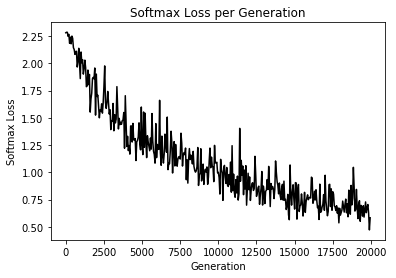

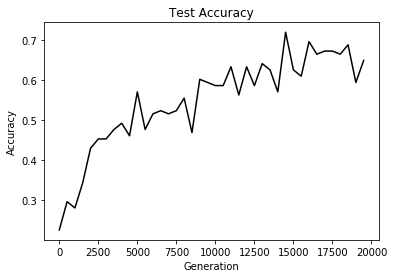

In [9]:
eval_indices = range(0, generations, eval_every)
output_indices = range(0, generations, output_every)

plt.plot(output_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

plt.plot(eval_indices, test_accuracy, 'k-')
plt.title('Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.show()